In [1]:
import warnings

warnings.filterwarnings("ignore")

import itertools
import json
import math
import os
import re
import sys
from collections import Counter
from copy import deepcopy
from functools import reduce
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from networkx.algorithms.shortest_paths.weighted import dijkstra_path_length
from rich import print
from tqdm import tqdm

In [2]:
def plot_mtx(mtx, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.matshow(mtx, cmap=plt.cm.Blues)
    plt.plot()

In [3]:
fp = "input.txt"
with open(fp, "r") as f:
    lines = f.read().split("\n")
wind_li = [l for l in lines[0]]
wind_deno = len(wind_li)
print(wind_deno)

10091

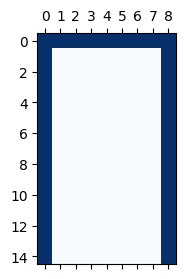

In [4]:
# init chamber mtx
chamber = np.zeros((10000, 9), dtype="int8")

chamber[:, 0] = 3
chamber[:, 8] = 3
chamber[0, :] = 3

plot_mtx(chamber[:15, :], figsize=(3, 3))

In [5]:
def extract_mtx(mtx, pos, size=4):
    i, j = pos[0], pos[1]
    if j < 0:
        return np.c_[
            np.full((size, -j), 3, dtype="int8"), mtx[i : i + size, 0 : j + size]
        ]
    elif j + size >= mtx.shape[1]:
        return np.c_[
            mtx[i : i + size, j : j + size],
            np.full((size, j + size - mtx.shape[1]), 3, dtype="int8"),
        ]
    else:
        return mtx[i : i + size, j : j + size].copy()

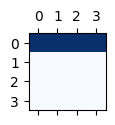

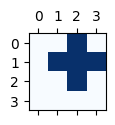

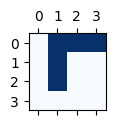

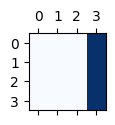

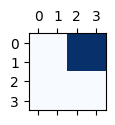

In [6]:
rock0 = np.zeros((4, 4), dtype="int8")
rock0[0, :] = 1
plot_mtx(rock0, figsize=(1, 1))

rock1 = np.zeros((4, 4), dtype="int8")
rock1[0, 2] = 1
rock1[1, 1:] = 1
rock1[2, 2] = 1
plot_mtx(rock1, figsize=(1, 1))

rock2 = np.zeros((4, 4), dtype="int8")
rock2[0, 1:] = 1
rock2[0:3, 1] = 1
plot_mtx(rock2, figsize=(1, 1))

rock3 = np.zeros((4, 4), dtype="int8")
rock3[:, -1] = 1
plot_mtx(rock3, figsize=(1, 1))

rock4 = np.zeros((4, 4), dtype="int8")
rock4[0, -2:] = 1
rock4[1, -2:] = 1
plot_mtx(rock4, figsize=(1, 1))

rock_li = [rock0, rock1, rock2, rock3, rock4]

True

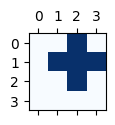

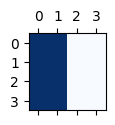

In [7]:
def check_stopped(rock, space):
    return np.any((rock == 1) & (space != 0))


# test
rock = rock_li[1]
space = extract_mtx(chamber, [10, -1])
plot_mtx(rock, figsize=(1, 1))
plot_mtx(space, figsize=(1, 1))
check_stopped(rock, space)

In [8]:
add_hight_dict = {0: 1, 1: 3, 2: 3, 3: 4, 4: 2}  # depends on rock type


def add_loaded_rock(mtx, rock_idx, pos, top_row):
    rock = rock_li[rock_idx]
    for i in range(rock.shape[0]):
        for j in range(rock.shape[1]):
            if (0 <= pos[1] + j < mtx.shape[1]) and (rock[i, j] == 1):
                mtx[pos[0] + i, pos[1] + j] = 2
    return max(add_hight_dict[rock_idx] + pos[0] - 1, top_row)

Answer to Q1: 3219

CPU times: user 545 ms, sys: 3.17 ms, total: 548 ms
Wall time: 196 ms


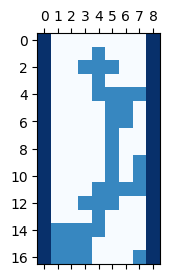

In [9]:
%%time


def count_top_row(num_rock, plot_top_row=False, collect_info=False):
    # init chamber mtx
    tall_size = 1_000_000
    chamber = np.zeros((tall_size, 9), dtype="int8")

    chamber[:, 0] = 3
    chamber[:, 8] = 3
    chamber[0, :] = 3

    keep_top_row = 500

    rock_count = 0
    step_count = -1
    top_row = 0
    last_top = 0
    total_top = 0

    if collect_info:
        rock_top_dict = {}
        rock_step_dict = {}

    while True:
        # add new rock
        rock_idx = rock_count % len(rock_li)
        rock = rock_li[rock_idx]
        # get rock pos
        rock_pos = np.array([top_row + 4, 2])
        while True:  # until it loads
            step_count += 1
            # get wind
            wind = wind_li[step_count % wind_deno]
            # ">": move right, j->j-1
            # "<": move left, j->j+1
            temp_rock_pos = rock_pos + np.array([0, -1 if wind == ">" else 1])
            if not check_stopped(rock, extract_mtx(chamber, temp_rock_pos)):
                # move
                rock_pos = temp_rock_pos
            # move 1 step down
            temp_rock_pos = rock_pos + np.array([-1, 0])
            if check_stopped(rock, extract_mtx(chamber, temp_rock_pos)):
                # loaded, update top_row
                top_row = add_loaded_rock(chamber, rock_idx, rock_pos, top_row)
                # remove rocks
                if top_row > tall_size - 20:
                    total_top += tall_size - keep_top_row
                    top_row = top_row - tall_size + keep_top_row
                    last_top = top_row

                    chamber = np.vstack(
                        (
                            chamber[-keep_top_row:, :],
                            np.zeros((tall_size - keep_top_row, 9), dtype="int8"),
                        )
                    )
                    chamber[:, 0] = 3
                    chamber[:, 8] = 3
                    chamber[0, :] = 3

                break
            else:
                # move
                rock_pos = temp_rock_pos

        rock_count += 1
        if collect_info:
            if rock_count % len(rock_li) == 0:
                rock_top_dict[rock_count] = total_top + top_row
                rock_step_dict[rock_count] = step_count + 1
        if rock_count >= num_rock:
            total_top += top_row
            break
    if plot_top_row:
        plot_mtx(
            np.flip(np.flip(chamber[top_row - 15 : top_row + 2, :], 1), 0),
            figsize=(3, 3),
        )
    if collect_info:
        return rock_step_dict, rock_top_dict
    else:
        return total_top


print(f"Answer to Q1: {count_top_row(2022, plot_top_row=True)}")

In [10]:
%%time
rock_step_dict, rock_top_dict = count_top_row(
    50000, plot_top_row=False, collect_info=True
)

CPU times: user 4.39 s, sys: 25.9 ms, total: 4.42 s
Wall time: 3.91 s


In [11]:
# Find start loop
gap_size = wind_deno * len(rock_li)
all_repeat_li = []
for i in range(len(rock_li), len(rock_step_dict) // 2, len(rock_li)):
    if rock_step_dict[i] + gap_size in rock_step_dict.values():
        all_repeat_li.append(i)
for i in range(len(all_repeat_li) - 1):
    if all_repeat_li[i + 1] - all_repeat_li[i] == len(rock_li):
        start_loop = all_repeat_li[i]
        break
# Find loop length
for k, v in rock_step_dict.items():
    if v == rock_step_dict[start_loop] + gap_size:
        loop_length = k - start_loop
# Find loop gain
loop_gain = rock_top_dict[loop_length + start_loop] - rock_top_dict[start_loop]
print(
    f"Loop start from: {start_loop}\nLoop length: {loop_length}\nLoop gain: {loop_gain}"
)

Loop start from: 210
Loop length: 8700
Loop gain: 13770

In [12]:
target_loop = 1000000000000
final_top_row = (target_loop - start_loop) // loop_length * loop_gain + rock_top_dict[
    (target_loop - start_loop) % loop_length + start_loop
]
print(f"Answer to Q2: {final_top_row}")

Answer to Q2: 1582758620701

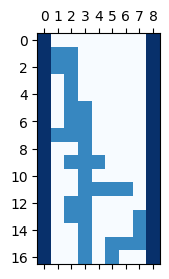

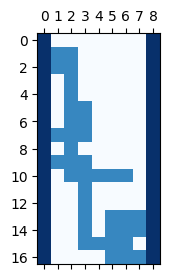

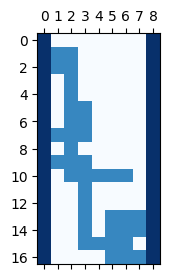

In [13]:
for i in range(3):
    count_top_row(start_loop + loop_length * i, plot_top_row=True)